In [59]:
import dowhy
import dowhy.datasets
import pandas as pd
from os.path import join
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from econml.orf import DMLOrthoForest, DROrthoForest
import sklearn

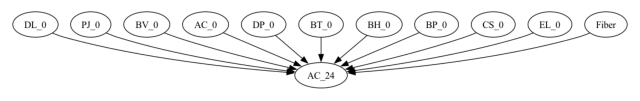

In [28]:
SPECIES = ['PJ', 'BV', 'AC', 'DP', 'BT', 'DL', 'BH', 'BP',
       'CS', 'EL']
FOLDER = join('Data', 'Species')
def load_data(filename):
    """Load growth data from a CSV file."""
    data = pd.read_csv(join(FOLDER, filename))
    
    species_0 = data[data['Time'] == 0][SPECIES].rename(lambda x: x + '_0', axis=1).reset_index(drop=True)
    species_24 = data[data['Time'] == 24][SPECIES].rename(lambda x: x + '_24', axis=1).reset_index(drop=True)
    fiber = data[data['Time'] == 0]['Treatments'].rename('Fiber').reset_index(drop=True)
    
    data = pd.concat([species_0, species_24, fiber], axis=1)
    data = data.reset_index(drop=True)
    return data
    

dynamics_AC = load_data('AC_growth_profile.csv')



organism_i = 'DL' # effector
organism_j = 'AC' # to predict

treatment = organism_i + '_0'
outcome = organism_j + '_24'

confounders = [x for x in dynamics_AC.columns if x not in [treatment, outcome] and '_0' in x] + ['Fiber']
# Build causal model
causal_graph = f"""
digraph {{
    {treatment} -> {outcome};
    {"; ".join([c + " -> " + outcome for c in confounders])};
}}
"""

model = dowhy.CausalModel(
    data=dynamics_AC,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders,
    graph=causal_graph
)
model.view_model()


In [29]:
dynamics_AC

,PJ_0,BV_0,AC_0,DP_0,BT_0,DL_0,BH_0,BP_0,CS_0,EL_0,...,BV_24,AC_24,DP_24,BT_24,DL_24,BH_24,BP_24,CS_24,EL_24,Fiber
0,0.000497,0.011394,0.007156,0.020968,0.002733,0.033991,0.002984,0.000497,0.000494,0.003338,...,0.207472,0.191100,0.469179,0.064864,0.730442,0.058850,0.046688,0.006322,0.069095,Inulin
1,0.000227,0.004001,0.006821,0.023491,0.002305,0.038726,0.004379,0.000728,0.000365,0.006409,...,0.069855,0.206212,0.498160,0.047937,0.809264,0.067727,0.084315,0.005259,0.115585,Inulin
2,0.000214,0.004692,0.005192,0.019954,0.003273,0.041992,0.000738,0.001651,0.000340,0.004721,...,0.081135,0.252463,0.418919,0.079912,0.844180,0.013374,0.043857,0.004630,0.083769,Inulin
3,0.000189,0.006381,0.004743,0.020710,0.006320,0.033357,0.001157,0.000583,0.000366,0.007159,...,0.108302,0.212902,0.433716,0.112760,0.674341,0.020620,0.038958,0.005278,0.124686,Inulin
4,0.000124,0.027779,0.004261,0.016034,0.001036,0.033113,0.002345,0.000167,0.000451,0.005286,...,0.519876,0.143990,0.377551,0.027891,0.751260,0.065918,0.002274,0.006635,0.120927,Inulin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.000000,...,0.118971,0.003856,0.322772,0.145149,0.029957,0.013639,0.006368,0.003711,0.000000,Xylan
155,0.000000,0.003750,0.003750,0.000000,0.003750,0.003750,0.000000,0.000000,0.000000,0.000000,...,0.208327,0.005025,0.000000,0.179686,0.070182,0.000000,0.000000,0.000000,0.000000,Xylan
156,0.000000,0.001875,0.001875,0.001875,0.000000,0.001875,0.001875,0.001875,0.001875,0.001875,...,0.259125,0.000852,0.305086,0.000000,0.068487,0.028422,0.018490,0.006136,0.226269,Xylan
157,0.002143,0.000000,0.002143,0.002143,0.000000,0.000000,0.002143,0.002143,0.002143,0.002143,...,0.000000,0.001833,0.479348,0.000000,0.000000,0.017377,0.053563,0.008348,0.107643,Xylan


In [30]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
──────(E[AC₂₄])
d[DL₀]         
Estimand assumption 1, Unconfoundedness: If U→{DL_0} and U→AC_24 then P(AC_24|DL_0,,U) = P(AC_24|DL_0,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [31]:

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
from econml.dml import CausalForestDML
import numpy as np

# Define variables
Y = dynamics_AC[outcome]                         # final abundance of species j
T = dynamics_AC[treatment]                       # initial abundance of species i


# One-hot encode fiber
fiber_encoder = OneHotEncoder(sparse_output=False).fit(dynamics_AC[['Fiber']])
fiber_encoded = fiber_encoder.transform(dynamics_AC[['Fiber']])
fiber_columns = fiber_encoder.get_feature_names_out(['Fiber'])
fiber_df = pd.DataFrame(fiber_encoded, columns=fiber_columns)

# Other X0 confounders: includes X0_j and X0_k≠i,j
other_covs = dynamics_AC[[col for col in confounders if col != 'Fiber']].reset_index(drop=True)

# Combine into covariate matrix
X = pd.concat([fiber_df, other_covs], axis=1)

# Fit EconML
model_y = LGBMRegressor(n_estimators=100, max_depth=3, random_state=0)
model_t = LGBMRegressor(n_estimators=100, max_depth=3, random_state=0)



estimator = CausalForestDML(
    model_y=RandomForestRegressor(),
    model_t=RandomForestRegressor(),
    n_estimators=200,
    min_samples_leaf=10,
    max_depth=6,
    discrete_treatment=False,
    random_state=42
)

# filter for T > 0
T = T[T > 0] # Filter out zero treatments
Y = Y[T.index]  # Align Y with filtered T
X = X.loc[T.index]  # Align X with filtered T
T = T.reset_index(drop=True)  # Reset index after filtering
Y = Y.reset_index(drop=True)  # Reset index after filtering
X = X.reset_index(drop=True)  # Reset index after filtering

estimator.fit(Y=Y, T=T, X=X)

inulin_data = X[X['Fiber_Inulin'] == 1].reset_index(drop=True)  # Filter for inulin treatment
laminarin_data = X[X['Fiber_Laminarin'] == 1].reset_index(drop=True)  # Filter for laminarin treatment
xylan_data = X[X['Fiber_Xylan'] == 1].reset_index(drop=True)  # Filter for xylan treatment
nocarb_data = X[X['Fiber_No Carb'] == 1].reset_index(drop=True)  # Filter for nocar treatment
# Estimate treatment effects for each fiber type
# τ̂_i→j for each sample
tau_hat_xylan = estimator.effect(xylan_data)  # τ̂_i→j for each sample
tau_hat_nocarb = estimator.effect(nocarb_data)  # τ̂_i→
tau_hat_inulin = estimator.effect(inulin_data)  # τ̂_i→j for each sample
tau_hat_laminarin = estimator.effect(laminarin_data)  # τ̂_i→j for each sample

T_inulin = T[inulin_data.index]  # Treatment values for inulin
T_laminarin = T[laminarin_data.index]  # Treatment values for laminarin
T_xylan = T[xylan_data.index]  # Treatment values for xylan
T_nocarb = T[nocarb_data.index]  # Treatment values for nocar


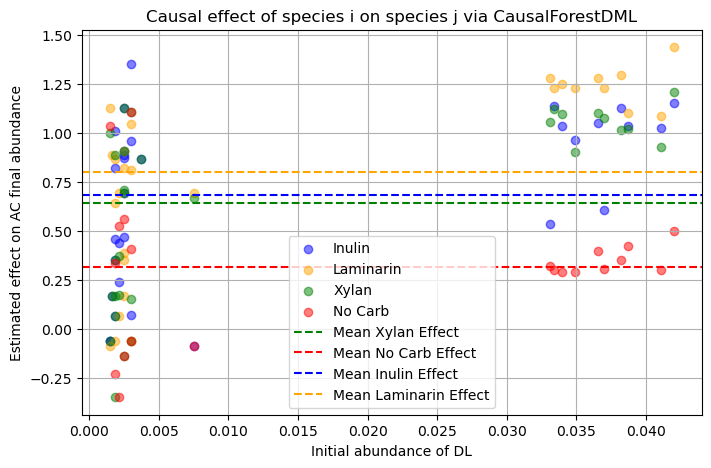

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.scatter(T_inulin, tau_hat_inulin, label='Inulin', alpha=0.5, color='blue')
plt.scatter(T_laminarin, tau_hat_laminarin, label='Laminarin', alpha=0.5, color='orange')
plt.scatter(T_xylan, tau_hat_xylan, label='Xylan', alpha=0.5, color='green')
plt.scatter(T_nocarb, tau_hat_nocarb, label='No Carb', alpha=0.5, color='red')  

plt.axhline(tau_hat_xylan.mean(), color='green', linestyle='--', label='Mean Xylan Effect')
plt.axhline(tau_hat_nocarb.mean(), color='red', linestyle='--', label='Mean No Carb Effect')
plt.axhline(tau_hat_inulin.mean(), color='blue', linestyle='--', label='Mean Inulin Effect')
plt.axhline(tau_hat_laminarin.mean(), color='orange', linestyle='--', label='Mean Laminarin Effect')
plt.legend()

plt.xlabel(f"Initial abundance of {organism_i}")
plt.ylabel(f"Estimated effect on {organism_j} final abundance")
plt.title("Causal effect of species i on species j via CausalForestDML")
plt.grid(True)
plt.show()

In [ ]:

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
from econml.dml import CausalForestDML
import numpy as np
class MicrobialCausalInteractionModel:
    SPECIES = ['PJ', 'BV', 'AC', 'DP', 'BT', 'DL', 'BH', 'BP',
               'CS', 'EL']
    def __init__(self, dynamic_data, objective_organism):
        self.objective_organism = objective_organism # Final abundance of the objective organism
        self.objective = objective_organism + '_growth'
        self.data = self.modify_data(dynamic_data)
        self.model = dict.fromkeys([x+'_0' for x in self.SPECIES] + ['Fiber'], None)
    def modify_data(self, data):

        species_0 = data[data['Time'] == 0][SPECIES].rename(lambda x: x + '_0', axis=1).reset_index(drop=True)
        species_24 = data[data['Time'] == 24][SPECIES].rename(lambda x: x + '_24', axis=1).reset_index(drop=True)
        fiber = data[data['Time'] == 0]['Treatments'].rename('Fiber').reset_index(drop=True)
        
        # growth of objective organism
        objective_growth = species_24[self.objective_organism + '_24'] - species_0[self.objective_organism + '_0']       
        objective_growth = objective_growth.rename(self.objective).reset_index(drop=True) 
        data = pd.concat([species_0, species_24, fiber, objective_growth], axis=1)
        data = data.reset_index(drop=True)
        return data
    
    def fit_organism_treatment(self, treatment_organism):
        '''Fit the model for a specific treatment organism.
        Update the model dictionary with the fitted model for the treatment organism.
        Args:
            treatment_organism (str): The organism to use as treatment.
        returns:
            None
        
        '''
        treatment = treatment_organism + '_0'
        outcome = self.objective 
        
        confounders = [x for x in self.data.columns if x not in [treatment, outcome] and '_0' in x] + ['Fiber']
        # Build causal model
        estimator = CausalForestDML(
            model_y=LGBMRegressor(n_estimators=100, max_depth=10, random_state=0),
            model_t=LGBMRegressor(n_estimators=100, max_depth=10, random_state=0),
            discrete_treatment=False,
        )
        
        
        # fiber encoding
        fiber_encoder = OneHotEncoder(sparse_output=False).fit(self.data[['Fiber']])
        fiber_encoded = fiber_encoder.transform(self.data[['Fiber']])
        fiber_columns = fiber_encoder.get_feature_names_out(['Fiber'])
        
        X = self.data[[col for col in confounders if col != 'Fiber']].reset_index(drop=True)
        fiber_df = pd.DataFrame(fiber_encoded, columns=fiber_columns)
        X = pd.concat([fiber_df, X], axis=1)
        
        T = self.data[treatment]
        
        # T = self.convert_treatment(T)  # Convert treatment to binary
        
        
        
        # filter for T > 0
        Y = self.data[outcome]
        # filter for T > 0
        # Fit the model
        estimator.fit(Y=Y, T=T, X=X, inference = 'blb')

        self.model[treatment] = [T, Y, X, estimator]
    
    def fit_all_organism_treatments(self):
        for organism in self.SPECIES:
            if organism != self.objective_organism.strip('_growth') :
                self.fit_organism_treatment(organism) 
                
        

    def mean_effect_organism(self, treatment_organism, fiber):
        if treatment_organism + '_0' not in self.model:
            raise ValueError(f"Model for {treatment_organism} not fitted.")
        treatment = treatment_organism + '_0'
        estimator = self.model[treatment]
        # Get the data for the treatment organism
        
        T, Y, X, model = estimator
        # Filter for the specified fiber treatment
    
        # Estimate treatment effects for the specified fiber type
        tau_hat = model.effect(X)  # τ̂_i→j for each sample     
        # Calculate mean effect
        
        dict_fiber_effect = dict.fromkeys(['Inulin', 'Laminarin', 'Xylan', 'No Carb'], None)
        
        for fiber_type in dict_fiber_effect.keys():
            fiber_data = X[X['Fiber_' + fiber_type] == 1].reset_index(drop=True)
            tau_hat_fiber = model.effect(fiber_data)  # τ̂_i→j for each sample
            dict_fiber_effect[fiber_type] = {
            'mean': np.mean(tau_hat_fiber),
            'std': np.std(tau_hat_fiber),
            'n': len(tau_hat_fiber),
            'tau_hat': tau_hat_fiber  # Optional: keep raw values
        }
        return dict_fiber_effect
    
    def fit_fiber_treatment(self):
        """Fit the model for a specific fiber treatment.
        Update the model dictionary with the fitted model for the fiber treatment.
        """
        treatment = 'Fiber'
        outcome = self.objective
        
        confounders = [x for x in self.data.columns if x not in [treatment, outcome] and '_0' in x]
        # Build causal model    
        T = self.data[treatment]
        Y = self.data[outcome]
        X = self.data[[col for col in confounders if col != 'Fiber']].reset_index(drop=True)
        
        model_causal = CausalForestDML(
            model_y=LGBMRegressor(n_estimators=100, max_depth=10, random_state=0),
            model_t=LGBMClassifier(n_estimators=100, max_depth=10, random_state=0),
            discrete_treatment=True,
        )
        
        model_causal.fit(Y=Y, T=T, X=X, inference='blb')
        
        self.model[treatment] = [T, Y, X, model_causal]
        
    def mean_effect_fiber(self):
        
        T, Y, X, model = self.model['Fiber']
        # Filter for the specified fiber treatment
        # Estimate treatment effects for the specified fiber type
        dict_fiber_effect = dict.fromkeys(['Inulin', 'Laminarin', 'Xylan', 'No Carb'], None)
        for fiber_type in dict_fiber_effect.keys():
            fiber_data = X[X['Fiber_' + fiber_type] == 1].reset_index(drop=True)
            tau_hat_fiber = model.effect(fiber_data, T = fiber_type)  # τ̂_i→j for each sample
            dict_fiber_effect[fiber_type] = {
                'mean': np.mean(tau_hat_fiber),
                'std': np.std(tau_hat_fiber),
                'n': len(tau_hat_fiber),
                'tau_hat': tau_hat_fiber  # Optional: keep raw values
            }
    
dynamics_AC = pd.read_csv(join(FOLDER, 'AC_growth_profile.csv'))
micro_AC = MicrobialCausalInteractionModel(dynamics_AC, 'AC')
micro_AC.fit_all_organism_treatments()
micro_AC.fit_fiber_treatment()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 11
[LightGBM] [Info] Start training from score 0.001219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
mean_effect_fiber